In [28]:
import numpy as np
from matplotlib import pyplot as plt
import profess_io as pio
import glob
import os

In [38]:
trajectory_dir = trajectory_dir = '/home/misa/projects/APDFT-CPMD/data/BOMD/Si64_hc_NPT/QMAS_5e4/trajectories'
trajectories = glob.glob(os.path.join(trajectory_dir, 'ion.*.dat'))
ion_file_numbers = np.arange(0, 4620, 10)
ion_file_numbers[0] = 1
pos = get_positions(trajectory_dir, ion_file_numbers)
np.save('/home/misa/projects/APDFT-CPMD/data/BOMD/data_Guido/Si64_step4610', pos[-1])

In [29]:
def get_lv_comp(lvs, comp):
    """
    returns lattice vector component
    """
    a_comp = []
    for i in range(len(lvs)):
        a_comp.append( lvs[i][comp[0]][comp[1]] )
    return(np.array(a_comp))

def get_positions(trajectory_dir, ion_numbers):
    trajectories = glob.glob(os.path.join(trajectory_dir, 'ion.*.dat'))
    coords = []
    for i in ion_numbers:
        if i == 0:
            path = os.path.join(trajectory_dir, f'ion.1.dat')
        else:
            path = os.path.join(trajectory_dir, f'ion.{i}.dat')
        coords_step = np.array(pio.parse_ion_file(path))
        coords.append(coords_step)
    coords = np.array(coords)
    return(coords)

def collect_data(file, ion_numbers=None, trajectory_dir = None, keys='all'):
    if keys == 'all':
        data = {'ekin':[], 'epot':[], 'frac_x':[], 'frac_y':[], 'frac_z':[], 'lattice_vectors': [], 'pressure': [], 'temperature': [], 'volume': []}
    else:
        data = {key: [] for key in keys}
        
    for k in data.keys():
        # pressure and volume will be calculated later
        if k not in ['volume']:
            data[k] = pio.parse_out_file(file, k)
            data[k] = np.array(data[k])
        
    # get lattice vector components
    if 'lattice_vectors' in data:
        for i in range(3):
            for j in range(3):
                data[f'l_{i}{j}'] = get_lv_comp(data['lattice_vectors'], (i,j))
    
    # calculate volume
    if 'volume' in data:
        for l in data['lattice_vectors']:
            data['volume'].append(np.linalg.det(l))
        data['volume'] = np.array(data['volume'])
    
    # calculate pressure
    if 'pressure' in data:
        bohr2m = 5.29177e-11
        auf2N = 8.2387225e-8
        data['pressure'] = data['pressure']/data['volume']*auf2N/bohr2m**2
    
    # get atom positions
    if trajectory_dir:
        data['positions'] = get_positions(trajectory_dir, ion_numbers)
        
        
    return(data)

def plot_data(data, num_plots = 8):
    plt.rcParams['figure.figsize'] = [10,40]
    plt.rcParams['font.size'] = 15
    fig, ax = plt.subplots(num_plots,1)
    
    ax[0].plot(data['time'], data['pressure'])
    ax[0].set_xlabel(r'$t$ (fs)')
    ax[0].set_ylabel(r'$p$ (Pa?)')
    
    # plot l_ii
    for i in range(3):
        ax[1].plot(data['time'], data[f'l_{i}{i}'], label = f'a_{i}{i}')
        ax[1].set_xlabel(r'$t$ (fs)')
        ax[1].set_ylabel(r'$a_{ii}$ (Ang)')
        ax[1].legend()

    # temperature
    ax[2].plot(data['time'], data['temperature'])
    ax[2].set_xlabel(r'$t$ (fs)')
    ax[2].set_ylabel(r'$T$ (K)')

    # epot
    ax[3].plot(data['time'], data['epot'])
    ax[3].set_xlabel(r'$t$ (fs)')
    ax[3].set_ylabel(r'$E_{\rm{pot}}$ (eV)')

    # ekin
    ax[4].plot(data['time'], data['ekin'])
    ax[4].set_xlabel(r'$t$ (fs)')
    ax[4].set_ylabel(r'$E_{\rm{kin}}$ (eV)')
    
    if 'positions' in data:
        # coordinates
        for ai, c in zip([5,6,7], [0,1,2]):
            plot_coordinate(ax, ai, data['positions'], c)
    return(fig,ax)
    
def plot_coordinate(ax, ax_idx, positions, coord):
    for atom in range(positions.shape[1]):
        ax[ax_idx].plot(positions[:,atom,coord], label = f'Si {atom}')
    ax[ax_idx].set_xlabel(r'$t$ (fs)')
    if coord == 0:
        coord_label = 'x'
    elif coord == 1:
        coord_label = 'y'
    elif coord == 2:
        coord_label = 'z'
    ax[ax_idx].set_ylabel(coord_label)
    ax[ax_idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    

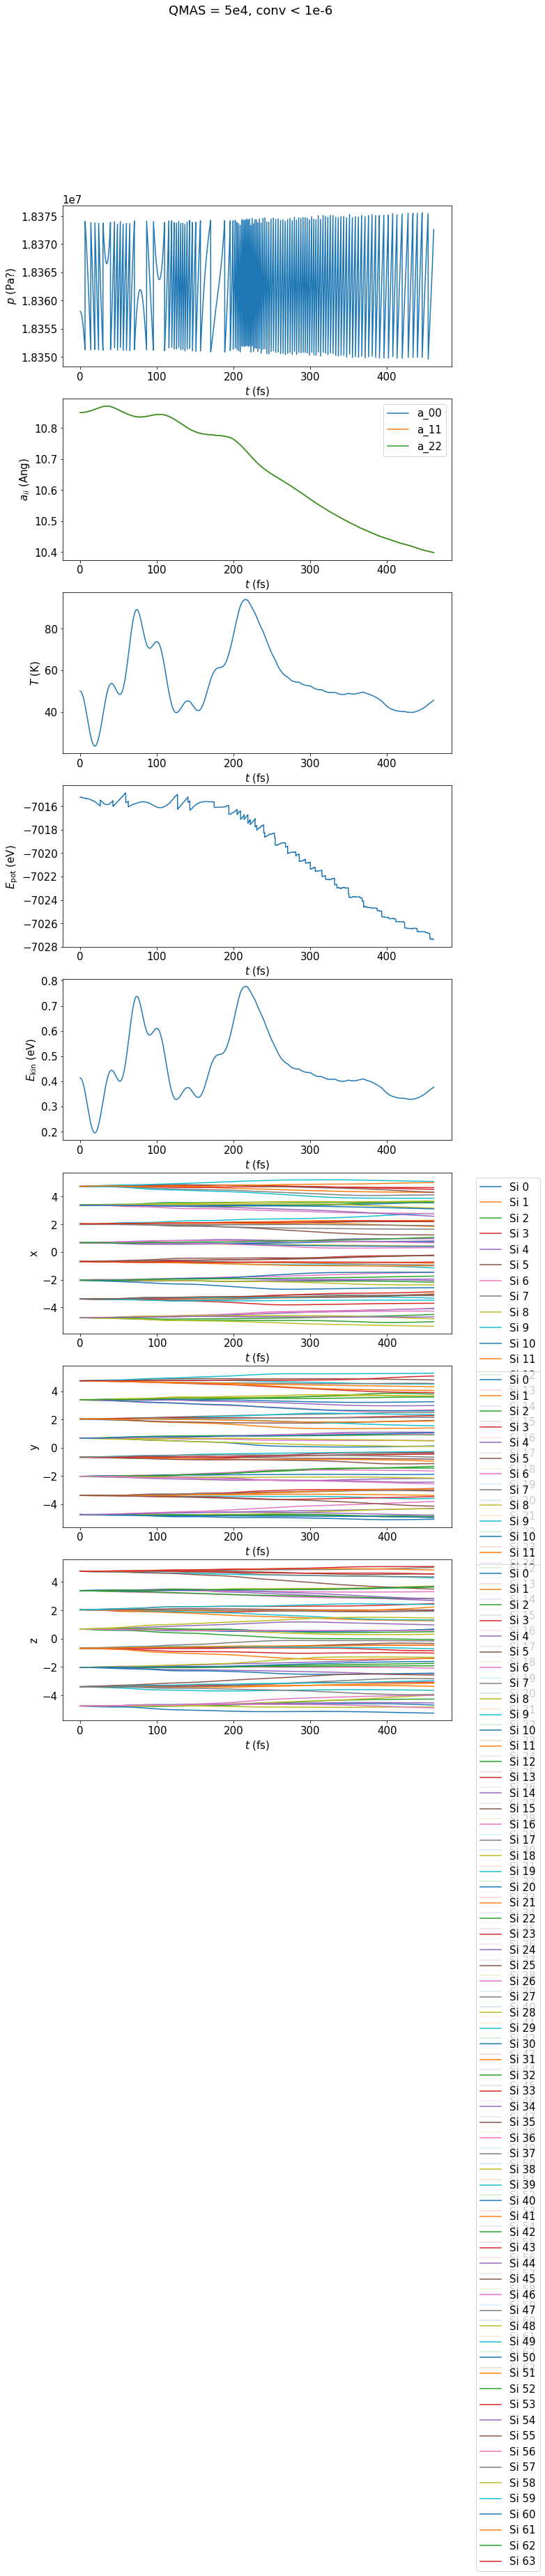

In [33]:
keys = {'ekin':[], 'epot':[], 'lattice_vectors': [], 'pressure':[], 'temperature': [], 'volume': []}
file = '/home/misa/projects/APDFT-CPMD/data/BOMD/Si64_hc_NPT/QMAS_5e4/hc.out'
ion_file_numbers = np.arange(0, 4620, 10)
ion_file_numbers[0] = 1
trajectory_dir = trajectory_dir = '/home/misa/projects/APDFT-CPMD/data/BOMD/Si64_hc_NPT/QMAS_5e4/trajectories'

data = collect_data(file, ion_file_numbers, trajectory_dir, keys)
# data['time'] = np.arange(0, 1000+0.1, 0.1)
data['time'] = np.linspace(0, len(data['ekin'])*0.1+0.1, len(data['ekin']))
f,a=plot_data(data)
p = '/home/misa/projects/APDFT-CPMD/data/BOMD/Si64_hc_NPT/figures/QMAS5e4_cubic.png'
f.suptitle('QMAS = 5e4, conv < 1e-6')
f.savefig(p, bbox_inches='tight')